## **Predicción de la vida útil restante (RUL) del motor de turbofán basado en Ciencia de Datos y Aprendizaje Automático (RANDOM FOREST).**

Random Forest (RF) es una excelente elección como modelo base para predecir la Remaining Useful Life (RUL) en el dataset C-MAPSS porque permite explorar relaciones no lineales complejas entre sensores y RUL sin requerir un preprocesamiento agresivo, como escalado o normalización estricta. Su capacidad para manejar datos ruidosos y seleccionar automáticamente características relevantes lo convierte en una herramienta valiosa para identificar patrones útiles que pueden guiar el diseño de modelos más complejos como LSTM o Transformers. Además, al analizar la importancia de variables y el comportamiento ante diferentes estrategias de preprocesamiento (como suavizado, dummies o escalado por condición), RF proporciona insights prácticos sobre qué transformaciones son realmente útiles para la predicción y cuáles podrían transferirse a modelos secuenciales más costosos computacionalmente.

En este notebook nos enfocaremos en el desarrollo del modelo de regresión lineal con Random Forest, el EDA y la importancia del estudio fueron desarrollados en el notebook Predicting Remaining Useful Life (RUL). Entonces se realizará:

- CARGAR LOS DATOS CONCATNEADOS
- PREPARACIÓN DE DATOS (AÑADIR LA RUL, AÑADIR LAS OPERACIONES POR CONDICIÓN, CLIP RUL, etc)
- SE REALIZARÁ UN MODELO LINEAL BASE (COMPARAR RESULTADOS).
- SE IMPLEMENTARÁ RANDOM FOREST CON AJUSTE DE HYPERPARAMETROS.
- SE VISUALIZARÁN CURVAS DE APRENDIZAJE.
- ANÁLISIS DE LA IMPORTANCIA DE CARACTERÍSTICAS.
- CONCLUSIONES


### **DESARROLLO**

#### **RECOLECCIÓN DE DATOS.**

La mayoría de los estudios empiezan con FD001 aplicando diferentes modelos hasta el más desafiante que es FD004 con modelos más complejos. Para este estudio nos centraremos en un modelo generalista, un modelo práctico para un entorno real que funcione en diferentes condiciones operativas (distintas condiciones de fallo, múltiples motores, diferentes regímenes de estrés), es decir concatenaremos los subset de datos, como los subconjuntos provienen de la misma distribución (mismo tipo de motores, mismos sensores, misma metodología de recolección) y solo varían en condiciones operativas, esto puede tener muchas ventajas como  aumentar la diversidad de datos y mejorar la robustez del modelo, ayudar a evitar overfitting y mejorar el entrenamiento de modelos de Machine Learning.

In [41]:
#Librerias importadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve # cruva de aprendizaje
import joblib
import os
import pickle
import random
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Configuración de la semilla para reproducibilidad
# Esta función establece la semilla para la reproducibilidad en experimentos de aprendizaje automático.
# Asegúrate de que todas las librerías relevantes usen la misma semilla para garantizar resultados consistentes.
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # Para reproducibilidad en hash de Python

# Llamar a la función para establecer la semilla
set_seed(42)
SEED = 42

In [42]:
#SEGMENTO DONDE DEFINO FUNCIONES A UTILIZAR

# Esta función evalúa el desempeño de un modelo de regresión
def evaluate(y_true, y_hat, label='test'):
    """
    Evalúa el desempeño de un modelo de regresión utilizando RMSE y R².

    Parámetros:
    y_true -- valores reales de la variable dependiente (array o lista)
    y_hat -- valores predichos por el modelo (array o lista)
    label -- etiqueta opcional para identificar el conjunto evaluado (por defecto: 'test')
    """

    # Calcula la Raíz del MSE (RMSE), que indica el error promedio en las mismas unidades que la variable dependiente
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    
    # Calcula el Coeficiente de Determinación (R²), que mide la proporción de varianza explicada por el modelo
    variance = r2_score(y_true, y_hat)

    # Imprime los resultados de evaluación con una etiqueta
    print(f'{label} set RMSE: {rmse:.4f}, R²: {variance:.4f}')

def add_remaining_useful_life(df):
    """
    Añade la columna RUL (Remaining Useful Life) al dataframe C-MAPSS.

    Parámetros:
    df -- DataFrame con datos de los sensores, que debe incluir las columnas 'unit_nr' y 'time_cycles'

    Retorna:
    Un nuevo DataFrame con una columna adicional llamada 'RUL'
    """

    # Paso 1: Calcular el número máximo de ciclos por cada unidad (motor)
    # Esto representa el ciclo en el que la unidad falló (fin de su vida útil)
    max_cycles_per_unit = df.groupby("unit_nr")["time_cycles"].transform('max')

    # Paso 2: Calcular el Remaining Useful Life restando el ciclo actual al máximo ciclo
    df["RUL"] = max_cycles_per_unit - df["time_cycles"]

    # Retornar el DataFrame modificado con la columna RUL añadida
    return df



In [43]:
def add_operating_conditions(df, alt_col='altitude', mach_col='mach', temp_col='temperature'):
    """
    Añade una columna 'operating_condition_id' al DataFrame en base a las combinaciones únicas
    de altitud, Mach y temperatura (redondeadas para evitar ruido).

    Parámetros:
    - df: DataFrame original con las columnas de altitud, Mach y temperatura.
    - alt_col, mach_col, temp_col: Nombres de las columnas correspondientes.

    Devuelve:
    - El DataFrame original con una nueva columna 'operating_condition_id'.
    - Un DataFrame con las combinaciones únicas de condiciones operativas.
    """
    df_grouped = df.copy()

    # Redondeo para agrupar correctamente condiciones similares
    df_grouped['alt'] = df_grouped[alt_col].round(0)
    df_grouped['Mach'] = df_grouped[mach_col].round(2)
    df_grouped['TRA'] = df_grouped[temp_col].round(1)

    # Crear tupla de condición operativa y asignar códigos únicos
    df_grouped['operating_condition'] = df_grouped[['alt', 'Mach', 'TRA']].apply(tuple, axis=1)
    df_grouped['operating_condition_id'] = df_grouped['operating_condition'].astype('category').cat.codes

    # Asignar la columna al DataFrame original
    df['operating_condition_id'] = df_grouped['operating_condition_id'].astype(int)

    # También retorna las combinaciones únicas y sus conteos por si lo necesitas
    condition_counts = df_grouped.groupby('operating_condition_id').size().reset_index(name='count')
    unique_conditions = df_grouped[['operating_condition_id', 'alt', 'Mach', 'TRA']].drop_duplicates()
    unique_conditions = unique_conditions.merge(condition_counts, on='operating_condition_id')

    return df, unique_conditions

In [44]:
# URL
FD=1
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

# definir el nombre de las columnas para fácil adaptación
index_names = ['unit_nr', 'time_cycles']
setting_names = ['altitude', 'mach', 'temperature']
sensor_names = ["t2", "t24", "t30", "t50",
    "p2", "p15", "p30",
    "nf", "nc",
    "epr", "ps30", "phi",
    "nrf", "nrc", "bpr", "farb", "htbleed",
    "nf_dmd", "pcnfr_dmd",
    "w31", "w32"]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])



In [45]:
# URL
FD=2
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

# leer dataset
train2 = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test2 = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test2 = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])


In [46]:
# URL
FD=3
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

# read data
train3 = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test3 = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test3 = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])


In [47]:
# URL
FD=4
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

# read data
train4 = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test4 = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test4 = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])

In [48]:
# Encontrar el valor máximo de unit_nr en train
max_unit_nr = train["unit_nr"].max()
# Ajustar los valores de unit_nr en train4 sumando el valor máximo de train esto para añadir secuecia en los motores
train2["unit_nr"] += max_unit_nr
max_unit_nr2 = train2["unit_nr"].max()
train3["unit_nr"] += max_unit_nr2
max_unit_nr3 = train3["unit_nr"].max()
train4["unit_nr"] += max_unit_nr3

# Concatenar los DataFrames por filas (axis=0)
train_final = pd.concat([train,train2,train3,train4], axis=0, ignore_index=True)

In [49]:
# Combinar los datos de prueba con las etiquetas RUL
test['RUL'] = y_test['RUL']
test2['RUL'] = y_test2['RUL']
test3['RUL'] = y_test3['RUL']
test4['RUL'] = y_test4['RUL']

# Encontrar el valor máximo de unit_nr en train
max_unit_nr = test["unit_nr"].max()
# Ajustar los valores de unit_nr en train4 sumando el valor máximo de train
test2["unit_nr"] += max_unit_nr
max_unit_nr2 = test2["unit_nr"].max()
test3["unit_nr"] += max_unit_nr2
max_unit_nr3 = test3["unit_nr"].max()
test4["unit_nr"] += max_unit_nr3

test_final = pd.concat([test,test2,test3,test4], axis=0, ignore_index=True)

In [50]:
# Guardar los datos de entrenamiento en un CSV
#train_final.to_csv('cmapps_entrenamiento_concatenado.csv', index=False)

# Guardar los datos de prueba en un CSV
#test_final.to_csv('cmapps_prueba_concatenado.csv', index=False)

#print("Archivos CSV generados con éxito: 'cmapps_entrenamiento_concatenado.csv' y 'cmapps_prueba_concatenado.csv'.")

In [51]:
train=train_final
test=test_final

In [52]:
train[['htbleed', 'nf_dmd']] = train[['htbleed', 'nf_dmd']].astype(float)
test[['htbleed', 'nf_dmd']] = test[['htbleed', 'nf_dmd']].astype(float)

#### **PREPARACIÓN DE DATOS**

In [53]:
#añadir el RUL al dataset
X_train=add_remaining_useful_life(train) 

In [54]:
#añadir las condiciones de operación
X_train, unique_conditions = add_operating_conditions(train)
unique_conditions

,operating_condition_id,alt,Mach,TRA,count
0,0,-0.0,-0.00,100.0,62633
1,4,35.0,0.84,100.0,17199
2,5,42.0,0.84,100.0,28853
3,3,25.0,0.62,60.0,17141
4,2,20.0,0.70,100.0,17213
5,1,10.0,0.25,100.0,17320


operating_condition_id
0    62633
5    28853
1    17320
2    17213
4    17199
3    17141
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribución de condiciones operativas en el conjunto de entrenamiento')

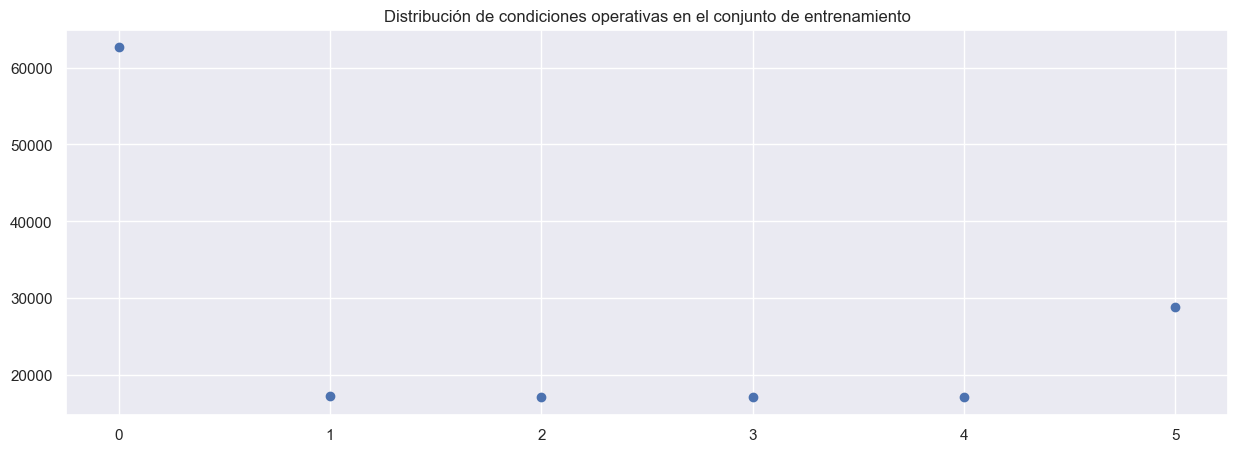

In [55]:
# ver la cantidad de datos por condición de operación
print(X_train['operating_condition_id'].value_counts())

plt.figure(figsize=(15,5))
plt.plot(X_train['operating_condition_id'].value_counts(), 'o')
plt.title('Distribución de condiciones operativas en el conjunto de entrenamiento')

In [56]:
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)# esta es con la clip RUL

In [57]:
X_test,unique_test=add_operating_conditions(test) 

In [58]:
# Dado que los valores RUL reales del conjunto de prueba solo se proporcionan para el último ciclo de cada motor, el conjunto de prueba se subdivide para representar lo mismo.
y_test = X_test.pop('RUL')  #rul real
y_test = y_test[y_test.notna()].reset_index(drop=True)
X_test = X_test.groupby('unit_nr').last().reset_index()

In [59]:
#One Hot Enconding
X_train_encoded = pd.get_dummies(X_train, columns=['operating_condition_id']).drop(columns=index_names+setting_names,axis=1)
X_test_encoded = pd.get_dummies(X_test, columns=['operating_condition_id']).drop(columns=index_names+setting_names,axis=1)

In [60]:
X_train_encoded.columns

Index(['t2', 't24', 't30', 't50', 'p2', 'p15', 'p30', 'nf', 'nc', 'epr',
       'ps30', 'phi', 'nrf', 'nrc', 'bpr', 'farb', 'htbleed', 'nf_dmd',
       'pcnfr_dmd', 'w31', 'w32', 'operating_condition_id_0',
       'operating_condition_id_1', 'operating_condition_id_2',
       'operating_condition_id_3', 'operating_condition_id_4',
       'operating_condition_id_5'],
      dtype='object')

### **MODELO.**

#### **REGRESION LINEAL RANDOM FOREST (EXPERIMENTO 1).**

Modelo optimizado sin preprocesamiento de datos, solo con las características de sensores y configuración

##### Proceso.

In [21]:

# Definir el pipeline para Random Forest
rf_pipeline1 = Pipeline([
    ('model', RandomForestRegressor(random_state=SEED))
])

# Hiperparámetros ajustados para mitigar overfitting
param_grid_rf1 = {
    'model__n_estimators': [100, 200],             # Más árboles puede ayudar a generalizar
    'model__max_depth': [5, 10, 15],               # Limitar profundidad para evitar árboles muy complejos
    'model__min_samples_split': [5, 10],           # Aumentar el mínimo para dividir un nodo
    'model__min_samples_leaf': [2, 4],             # Más muestras en hojas -> más generalización
    'model__max_features': ['sqrt', 'log2']        # Limitar número de características en splits
}

# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

In [ ]:
# Optimización con GridSearchCV para RF. 480 min tiempo de ejecución
grid_rf1 = GridSearchCV(rf_pipeline1, param_grid_rf1, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf, verbose=4)
grid_rf1.fit(X_train[setting_names+sensor_names], y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 1/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-62.074, test=-61.869) r2: (train=0.448, test=0.449) total time=  12.8s
[CV 2/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-61.832, test=-62.086) r2: (train=0.452, test=0.448) total time=  12.5s
[CV 3/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-62.040, test=-61.662) r2: (train=0.449, test=0.451) total time=  13.2s
[CV 4/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-61.986, test=-62

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [5, 10, 15],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4],
                         'model__min_samples_split': [5, 10],
                         'model__n_estimators': [100, 200]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=4)

In [23]:
best_grid_rf1 = grid_rf1.best_estimator_

# Comparación de resultados
rf_rmse1 = -grid_rf1.best_score_
print(f"Mejor RMSE Random Forest: {rf_rmse1:.4f}, Mejor configuración: {grid_rf1.best_params_}")

Mejor RMSE Random Forest: 50.3804, Mejor configuración: {'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}


##### Resultado.

In [24]:
y_pred_train_1 = best_grid_rf1.predict(X_train[setting_names+sensor_names])
y_pred_test_1 = best_grid_rf1.predict(X_test[setting_names+sensor_names])

evaluate(y_train, y_pred_train_1, 'train')
evaluate(y_test.clip(upper=125), y_pred_test_1)

train set RMSE: 44.8102, R²: 0.7123
test set RMSE: 38.8426, R²: 0.1482


#### **REGRESIÓN LINEAL RANDOM FOREST + CLIP RUL (EXPERIMENTO 2).**

En este caso reentrenaremos el mejor modelo optimizado encontrado anteriormente pero ahora con la variable objetivo adaptada (CLIP RUL) y estandar escaler global.

##### Reentreno

In [46]:
RF_reeval = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(
        n_estimators=200, 
        max_depth=15,                
        min_samples_split=5,                
        min_samples_leaf=2,
        max_features='sqrt',      
        random_state=SEED
        ))
])

In [ ]:
# Entrenamiento y evaluación 5 min tiempo
RF_reeval.fit(X_train[setting_names+sensor_names], y_train_clipped)
y_pred_2 = RF_reeval.predict(X_test[setting_names+sensor_names])
y_pred_train_2 = RF_reeval.predict(X_train[setting_names+sensor_names])

##### Resultado.

In [48]:
evaluate(y_train_clipped, y_pred_train_2, 'train')
evaluate(y_test.clip(upper=125), y_pred_2)

train set RMSE: 15.7369, R²: 0.8544
test set RMSE: 18.3348, R²: 0.8102


A partir de aquí todos los experimentos usaran clip rul.

#### **REGRESIÓN LINEAL RANDOM FOREST + ONE HOT ENCONDING (EXPERIMENTO 3).**

La idea es añadir One Hot Enconding al modelo anterior con escaler global, y verificar si en el modelo no lineal pues mejora en algo con las dummies. 

##### Proceso.

In [21]:
# Columnas numéricas.
numeric_features = ['t2', 't24', 't30', 't50', 'p2', 'p15', 'p30', 'nf', 'nc', 'epr', 
                   'ps30', 'phi', 'nrf', 'nrc', 'bpr', 'farb', 'htbleed', 'nf_dmd', 
                   'pcnfr_dmd', 'w31', 'w32']

# Columnas categóricas.
categorical_features = ['operating_condition_id']

In [22]:
from sklearn.compose import ColumnTransformer

# Preprocessor unificado
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='drop')  # Ignora columnas no listadas

In [23]:
# Definir el pipeline para Random Forest
rf_pipeline3 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=SEED))
])

# Hiperparámetros ajustados para mitigar overfitting
param_grid_rf3 = {
    'model__n_estimators': [100, 200],             # Más árboles puede ayudar a generalizar
    'model__max_depth': [5, 10, 15],               # Limitar profundidad para evitar árboles muy complejos
    'model__min_samples_split': [5, 10],           # Aumentar el mínimo para dividir un nodo
    'model__min_samples_leaf': [2, 4],             # Más muestras en hojas -> más generalización
    'model__max_features': ['sqrt', 'log2']        # Limitar número de características en splits
}

# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)

In [24]:
# Ajusta el preprocesador
preprocessor.fit(X_train[sensor_names+['operating_condition_id']])

# Obtén los nombres de las columnas de salida
feature_names = preprocessor.get_feature_names_out()

print("Columnas de salida:")
print(feature_names)

Columnas de salida:
['scaler__t2' 'scaler__t24' 'scaler__t30' 'scaler__t50' 'scaler__p2'
 'scaler__p15' 'scaler__p30' 'scaler__nf' 'scaler__nc' 'scaler__epr'
 'scaler__ps30' 'scaler__phi' 'scaler__nrf' 'scaler__nrc' 'scaler__bpr'
 'scaler__farb' 'scaler__htbleed' 'scaler__nf_dmd' 'scaler__pcnfr_dmd'
 'scaler__w31' 'scaler__w32' 'onehot__operating_condition_id_0'
 'onehot__operating_condition_id_1' 'onehot__operating_condition_id_2'
 'onehot__operating_condition_id_3' 'onehot__operating_condition_id_4'
 'onehot__operating_condition_id_5']


In [25]:
grid_rf3 = GridSearchCV(rf_pipeline3, param_grid_rf3, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf, verbose=4)
grid_rf3.fit(X_train[sensor_names+['operating_condition_id']], y_train_clipped)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 1/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-26.157, test=-26.182) r2: (train=0.598, test=0.596) total time=  16.4s
[CV 2/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-25.954, test=-25.949) r2: (train=0.604, test=0.604) total time=  18.0s
[CV 3/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-26.043, test=-26.101) r2: (train=0.601, test=0.600) total time=  14.5s
[CV 4/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-26.039, test=-26

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['t2',
                                                                          't24',
                                                                          't30',
                                                                          't50',
                                                                          'p2',
                                                                          'p15',
                                                                          'p30',
                                                                          'nf',
                                                                          'nc',
                                                                          'epr',
                                                                          'ps30',
                                                                          'phi',
                                                                          'nrf',
                                                                          'nrc',
                                                                          'bpr',
                                                                          'farb',
                                                                          'htbleed',
                                                                          'nf_dmd',
                                                                          'pcnfr_dmd',
                                                                          'w31',
                                                                          'w32']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown=...
                                                                         ['operating_condition_id'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [5, 10, 15],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4],
                         'model__min_samples_split': [5, 10],
                         'model__n_estimators': [100, 200]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=4)

In [ ]:
# Guardar grid_rf
#joblib.dump(grid_rf3, 'grid_rf3.pkl')

#print("Modelo guardado exitosamente: 'grid_rf3.pkl'.")

Modelo guardado exitosamente: 'grid_rf3.pkl'.


In [29]:
# Cargar el GridSearchCV completo
#grid_rf3 = joblib.load('grid_rf3.pkl')

#print("Modelo cargado exitosamente.")

In [26]:
best_grid_rf3 = grid_rf3.best_estimator_

# Comparación de resultados
rf_rmse3 = -grid_rf3.best_score_
print(f"Mejor RMSE Random Forest: {rf_rmse3:.4f}, Mejor configuración: {grid_rf3.best_params_}")

Mejor RMSE Random Forest: 18.0810, Mejor configuración: {'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}


##### Resultado.

In [27]:
y_pred_train_3 = best_grid_rf3.predict(X_train[sensor_names+['operating_condition_id']])
y_pred_test_3 = best_grid_rf3.predict(X_test[sensor_names+['operating_condition_id']])

evaluate(y_train_clipped, y_pred_train_3, 'train')
evaluate(y_test.clip(upper=125), y_pred_test_3)

train set RMSE: 15.7250, R²: 0.8546
test set RMSE: 18.2864, R²: 0.8112


##### Importancia de Características.

In [ ]:
selected_features=['scaler__t2' 'scaler__t24' 'scaler__t30' 'scaler__t50' 'scaler__p2'
 'scaler__p15' 'scaler__p30' 'scaler__nf' 'scaler__nc' 'scaler__epr'
 'scaler__ps30' 'scaler__phi' 'scaler__nrf' 'scaler__nrc' 'scaler__bpr'
 'scaler__farb' 'scaler__htbleed' 'scaler__nf_dmd' 'scaler__pcnfr_dmd'
 'scaler__w31' 'scaler__w32' 'onehot__operating_condition_id_0'
 'onehot__operating_condition_id_1' 'onehot__operating_condition_id_2'
 'onehot__operating_condition_id_3' 'onehot__operating_condition_id_4'
 'onehot__operating_condition_id_5']

In [ ]:
importances = best_grid_rf3.named_steps['model'].feature_importances_

# Ordenar las importancias
# Crear dataframe de importancias
feat_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

# Gráfico
sns.barplot(
    data=feat_importances,
    x='Importance',
    y='Feature',
    color='#440154',  
    hue='Feature',    
    palette='viridis', 
    dodge=False,      # Evita que separen las barras
    legend=False      # No mostrar leyenda redundante
)

# Personalización del gráfico
plt.title('Importancia de Características - Random Forest', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir valores de importancia a cada barra
for index, value in enumerate(feat_importances['Importance']):
    plt.text(value + 0.005,             # Posición X (valor + pequeño desplazamiento)
            index,                     # Posición Y (índice de la barra)
            f'{value:.3f}',            
            va='center',               
            fontsize=10)              

plt.tight_layo

#### **REGRESIÓN LINEAL RANDOM FOREST + ONE HOT ENCONDING + ESCALADO POR CONDICIÓN (EXPERIMENTO 4).**

El escalado por condición de operación en Random Forest (RF) es útil para evaluar si las diferencias en la escala de los sensores entre distintos modos de operación afectan el desempeño del modelo, incluso si RF no requiere escalado explícito. Aunque los árboles de decisión son invariantes a escalas, un mal alineamiento de las distribuciones entre condiciones puede introducir sesgos en la segmentación del árbol y dificultar la detección de patrones consistentes. Evaluar este tipo de escalado en RF permite obtener insights sobre la relevancia de normalizar los datos por contexto operativo, lo cual es especialmente valioso para modelos como LSTM o Transformers que sí son sensibles a las escalas y distribuciones de entrada.

La idea es verificar el desempeño de modelo no lineal frente a el escalado por condición de operación.

##### Proceso.

In [21]:
sensor_names = sensor_names
condition_column = 'operating_condition_id'
group_column = 'unit_nr'

In [33]:
# ------------------------------
# ConditionScaler personalizado
# ------------------------------
class ConditionScaler(BaseEstimator, TransformerMixin):
    def __init__(self, feature_columns, condition_column='operating_condition_id'):
        self.feature_columns = feature_columns
        self.condition_column = condition_column
        self.scalers_dict_ = {}
        
    def fit(self, X, y=None):
        X = X.astype({col: 'float64' for col in self.feature_columns})
        for condition in X[self.condition_column].unique():
            scaler = StandardScaler()
            scaler.fit(X.loc[X[self.condition_column] == condition, self.feature_columns])
            self.scalers_dict_[condition] = scaler
        return self
        
    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.feature_columns] = X_scaled[self.feature_columns].astype('float64')
        for condition, scaler in self.scalers_dict_.items():
            mask = X[self.condition_column] == condition
            X_scaled.loc[mask, self.feature_columns] = scaler.transform(X.loc[mask, self.feature_columns])
        return X_scaled

In [32]:
onehot_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), [condition_column]),
], remainder='passthrough',
    force_int_remainder_cols=False)

In [33]:
# Definir el pipeline para RF
rf_pipeline4 = Pipeline([
    ('condition_scaler', ConditionScaler(feature_columns=sensor_names, condition_column=condition_column)), # condición de operación
    ('onehot_encoder', onehot_transformer),
    ('model', RandomForestRegressor(random_state=SEED))
])

# Definir espacio de búsqueda
param_grid_rf4 = {
    'model__n_estimators': [100, 200],             # Más árboles puede ayudar a generalizar
    'model__max_depth': [5, 10, 15],               # Limitar profundidad para evitar árboles muy complejos
    'model__min_samples_split': [5, 10],           # Aumentar el mínimo para dividir un nodo
    'model__min_samples_leaf': [2, 4],             # Más muestras en hojas -> más generalización
    'model__max_features': ['sqrt', 'log2']        # Limitar número de características en splits
}

# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)

In [34]:
grid_rf4 = GridSearchCV(rf_pipeline4, param_grid_rf4, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf, verbose=4)
grid_rf4.fit(X_train[sensor_names+['operating_condition_id']], y_train_clipped)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 1/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-19.789, test=-19.844) r2: (train=0.770, test=0.768) total time=  15.4s
[CV 2/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-19.759, test=-19.873) r2: (train=0.770, test=0.768) total time=  14.6s
[CV 3/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-19.722, test=-19.880) r2: (train=0.771, test=0.768) total time=  15.0s
[CV 4/10] END model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-19.767, test=-19

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('condition_scaler',
                                        ConditionScaler(feature_columns=['t2',
                                                                         't24',
                                                                         't30',
                                                                         't50',
                                                                         'p2',
                                                                         'p15',
                                                                         'p30',
                                                                         'nf',
                                                                         'nc',
                                                                         'epr',
                                                                         'ps30',
                                                                         'phi',
                                                                         'nrf',
                                                                         'nrc',
                                                                         'bpr',
                                                                         'farb',
                                                                         'htbleed',
                                                                         'nf_dmd',
                                                                         'pcnfr_dmd',
                                                                         'w31',
                                                                         'w32'])),
                                       ('onehot_encoder',
                                        ColumnTransformer(force_int_remainder_cols=...
                                                                         ['operating_condition_id'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [5, 10, 15],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4],
                         'model__min_samples_split': [5, 10],
                         'model__n_estimators': [100, 200]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=4)

In [ ]:
# Guardar grid_rf
#joblib.dump(grid_rf4, 'grid_rf4.pkl')

#print("Modelo guardado exitosamente: 'grid_rf4.pkl'.")

Modelo guardado exitosamente: 'grid_rf4.pkl'.


In [36]:
# Cargar el GridSearchCV completo
#grid_rf4 = joblib.load('grid_rf4.pkl')

#print("Modelo cargado exitosamente.")

In [37]:
best_grid_rf4 = grid_rf4.best_estimator_

# Comparación de resultados
rf_rmse4 = -grid_rf4.best_score_
print(f"Mejor RMSE Random Forest: {rf_rmse4:.4f}, Mejor configuración: {grid_rf4.best_params_}")

Mejor RMSE Random Forest: 18.0017, Mejor configuración: {'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 200}


##### Resultado.

In [38]:
y_pred_train_4 = best_grid_rf4.predict(X_train[sensor_names+['operating_condition_id']])
y_pred_test_4 = best_grid_rf4.predict(X_test[sensor_names+['operating_condition_id']])

evaluate(y_train_clipped, y_pred_train_4, 'train')
evaluate(y_test.clip(upper=125), y_pred_test_4)

train set RMSE: 15.2493, R²: 0.8633
test set RMSE: 18.3808, R²: 0.8093


##### Importancia de Características.

In [ ]:
selected_features=['scaler__t2' 'scaler__t24' 'scaler__t30' 'scaler__t50' 'scaler__p2'
 'scaler__p15' 'scaler__p30' 'scaler__nf' 'scaler__nc' 'scaler__epr'
 'scaler__ps30' 'scaler__phi' 'scaler__nrf' 'scaler__nrc' 'scaler__bpr'
 'scaler__farb' 'scaler__htbleed' 'scaler__nf_dmd' 'scaler__pcnfr_dmd'
 'scaler__w31' 'scaler__w32' 'onehot__operating_condition_id_0'
 'onehot__operating_condition_id_1' 'onehot__operating_condition_id_2'
 'onehot__operating_condition_id_3' 'onehot__operating_condition_id_4'
 'onehot__operating_condition_id_5']

In [ ]:
importances = best_grid_rf4.named_steps['model'].feature_importances_

# Ordenar las importancias
# Crear dataframe de importancias
feat_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

# Gráfico
sns.barplot(
    data=feat_importances,
    x='Importance',
    y='Feature',
    color='#440154',  
    hue='Feature',    
    palette='viridis', 
    dodge=False,      # Evita que separen las barras
    legend=False      # No mostrar leyenda redundante
)

# Personalización del gráfico
plt.title('Importancia de Características - Random Forest', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir valores de importancia a cada barra
for index, value in enumerate(feat_importances['Importance']):
    plt.text(value + 0.005,             # Posición X (valor + pequeño desplazamiento)
            index,                     # Posición Y (índice de la barra)
            f'{value:.3f}',            
            va='center',               
            fontsize=10)              

plt.tight_layo

#### **REGRESIÓN LINEAL RANDOM FOREST (EXPERIMENTO 5).**

Pese a que demostramos que se tiene un mejor rendimiento con más características del dataset, realizamos aun feature selección para verificar si en modelos no lienales se mantiene el mismo patrón. Tambien hay que tomar en cuenta que, pese a que no es una buena práctica, los datos fueron preprocesados por fuera del pipeline, es decir se añadio la rul, la característica de la condición de operación y las dummies, se hizo el FIT con la variable X_train_encoded más la clip RUL.

##### Proceso.

In [ ]:
# Lista de valores para k
k_values = [14, 27]

# Definir el pipeline para Random Forest
rf_pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=mutual_info_regression)),
    ('model', RandomForestRegressor(random_state=SEED))
])

# Hiperparámetros ajustados para mitigar overfitting
param_grid_rf = {
    'feature_selection__k': k_values,              # Selección de características
    'model__n_estimators': [100, 200],             # Más árboles puede ayudar a generalizar
    'model__max_depth': [5, 10, 15],               # Limitar profundidad para evitar árboles muy complejos
    'model__min_samples_split': [5, 10],           # Aumentar el mínimo para dividir un nodo
    'model__min_samples_leaf': [2, 4],             # Más muestras en hojas -> más generalización
    'model__max_features': ['sqrt', 'log2']        # Limitar número de características en splits
}

# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)

In [ ]:
# Optimización con GridSearchCV para Ridge.
# 960 min de ejecución aproximadamente.
grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf, verbose=4)
grid_rf.fit(X_train_encoded, y_train_clipped)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10] END feature_selection__k=14, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-25.710, test=-25.742) r2: (train=0.612, test=0.609) total time=  59.1s
[CV 2/10] END feature_selection__k=14, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-25.598, test=-25.602) r2: (train=0.615, test=0.614) total time=  46.2s
[CV 3/10] END feature_selection__k=14, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; neg_root_mean_squared_error: (train=-25.801, test=-25.864) r2: (train=0.608, test=0.607) total time=  45.2s
[CV 4/10] END feature_selection__k=14, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model_

In [35]:
grid_rf

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(score_func=<function mutual_info_regression at 0x000001C56DBFC680>)),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'feature_selection__k': [14, 27],
                         'model__max_depth': [5, 10, 15],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4],
                         'model__min_samples_split': [5, 10],
                         'model__n_estimators': [100, 200]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=4)

In [ ]:
best_grid_rf = grid_rf.best_estimator_

# Comparación de resultados
rf_rmse = -grid_rf.best_score_
print(f"Mejor RMSE Random Forest: {rf_rmse:.4f}, Mejor configuración: {grid_rf.best_params_}")

Mejor RMSE Ridge: 18.0809, Mejor configuración: {'feature_selection__k': 27, 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}


In [ ]:
# Guardar grid_ridge
#joblib.dump(grid_rf, 'grid_rf_full.pkl')

# Guardar best_ridge
#joblib.dump(best_grid_rf, 'rf_best_model.pkl')

#print("Modelos guardados exitosamente: 'grid_rf_full.pkl' y 'rf_best_model.pkl'.")

In [ ]:
# Cargar el GridSearchCV completo (incluye CV results, etc.)
#grid_rf = joblib.load('grid_rf_full.pkl')

# Cargar el mejor modelo (best_estimator_)
#best_grid_rf = joblib.load('rf_best_model.pkl')

# Confirmar que se cargaron correctamente
#print("Modelos cargados exitosamente.")

Modelos cargados exitosamente.


In [56]:
best_grid_rf = grid_rf.best_estimator_

# Comparación de resultados
rf_rmse = -grid_rf.best_score_
print(f"Mejor RMSE Random Forest: {rf_rmse:.4f}, Mejor configuración: {grid_rf.best_params_}")

Mejor RMSE Random Forest: 18.0809, Mejor configuración: {'feature_selection__k': 27, 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}


##### Resultado.

In [54]:
y_hat_trainreg = best_grid_rf.predict(X_train_encoded)
y_hat_testreg = best_grid_rf.predict(X_test_encoded)

evaluate(y_train, y_hat_trainreg, 'train')
evaluate(y_test.clip(upper=125), y_hat_testreg)

train set RMSE: 15.7251, R²: 0.8546
test set RMSE: 18.2904, R²: 0.8111


Se observa un ligero overfitting pero aun asi el modelo generaliza bien los datos, lo verificaremos con curvas de aprendiizaje. Existe una mejora sustancial en Random Forest, añadiendo el clip rul de hecho la tabla de resultados queda así. 

**Tabla 1. Comparación de diferentes modelos.**

| Métrica       | Modelo Base General | Modelo Base Dummies | Ridge Estándar | Ridge + ConditionScaler | **RF Optimizado experimento 5(clip RUL)** |
|---------------|---------------------|---------------------|----------------|-------------------------|-----------------------------|
| **RMSE Train**| 55.7095             | 55.4796             | 51.4932        | 51.4213                 | **15.7251**                 |
| **R² Train**  | 0.5553              | 0.5589              | 0.6200         | 0.6211                  | **0.8546**                  |
| **RMSE Test** | 44.0242             | 43.5085             | 39.5969        | 39.3696                 | **18.2904**                 |
| **R² Test**   | 0.2570              | 0.2743              | 0.3989         | 0.4058                  | **0.8111**                  |

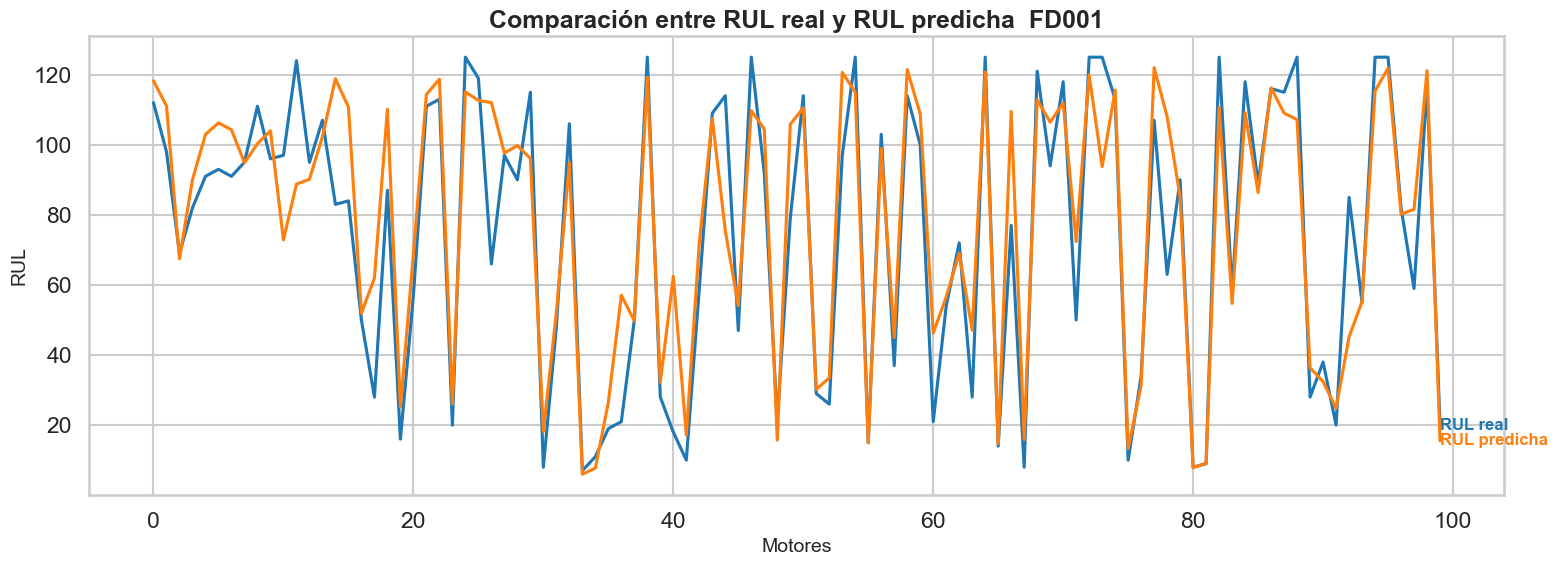

In [55]:
# Estilo de Seaborn
sns.set(style="whitegrid", context="talk")

# Crear DataFrame con resultados
df_resultados = pd.DataFrame({
    'RUL real': y_test.clip(upper=125)[:100],
    'RUL predicha': y_hat_testreg[:100]
})

plt.figure(figsize=(16, 6))
sns.lineplot(data=df_resultados['RUL real'], label=None, color='#1f77b4')
sns.lineplot(data=df_resultados['RUL predicha'], label=None, color='#ff7f0e')

# Añadir texto directamente en las curvas
plt.text(len(df_resultados)-1, df_resultados['RUL real'].iloc[-1], 'RUL real',
         color='#1f77b4', fontsize=12, va='center', ha='left', fontweight='bold')

plt.text(len(df_resultados)-1, df_resultados['RUL predicha'].iloc[-1], 'RUL predicha',
         color='#ff7f0e', fontsize=12, va='center', ha='left', fontweight='bold')

plt.title('Comparación entre RUL real y RUL predicha  FD001', fontsize=18, weight='bold')
plt.xlabel('Motores', fontsize=14)
plt.ylabel('RUL', fontsize=14)

plt.tight_layout()
plt.show()

##### **CURVAS DE APRENDIZAJE.**

In [59]:
train_sizes, train_scores, val_scores = learning_curve(
    best_grid_rf, X_train_encoded, y_train.clip(upper=125), cv=rkf, scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

In [60]:
train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

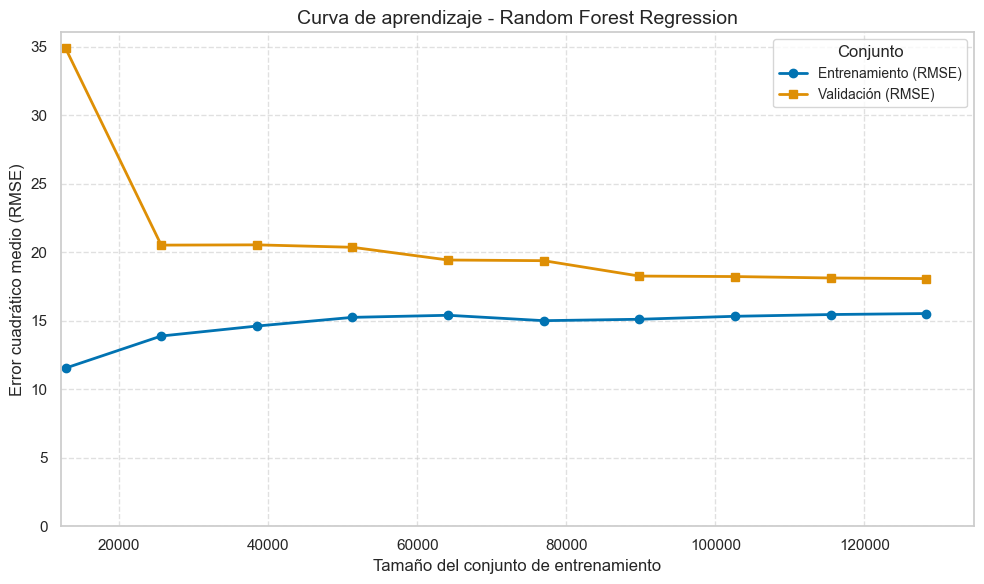

In [61]:
# Estilo general
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Colores accesibles con contraste
colors = sns.color_palette("colorblind")

# Líneas con marcadores y bordes para mejor visibilidad
plt.plot(train_sizes, train_rmse, label='Entrenamiento (RMSE)', marker='o', color=colors[0], linewidth=2)
plt.plot(train_sizes, val_rmse, label='Validación (RMSE)', marker='s', color=colors[1], linewidth=2)

# Etiquetas y título con tipografía clara
plt.xlabel('Tamaño del conjunto de entrenamiento', fontsize=12)
plt.ylabel('Error cuadrático medio (RMSE)', fontsize=12)
plt.title('Curva de aprendizaje - Random Forest Regression', fontsize=14)


plt.ylim(bottom=0)  # evita que el eje Y recorte datos
plt.xlim([min(train_sizes)*0.95, max(train_sizes)*1.05])

# Leyenda clara con mejor contraste
plt.legend(title='Conjunto', loc='upper right', fontsize=10)

# Cuadrícula sutil
plt.grid(True, linestyle='--', alpha=0.6)

# Acomodar todo bien al canvas
plt.tight_layout()
plt.show()


Mejora clara con más datos: A medida que aumenta el tamaño del conjunto de entrenamiento, el RMSE de validación disminuye considerablemente, lo que muestra que el modelo sigue aprendiendo y generalizando mejor con más ejemplos. probablemente solucionaríamos el problema de la rul con Random Forest si tuvieramos mas datos pero ese no es el caso.

##### **IMPORTANCIA DE CARACTERÍSTICAS.**

In [38]:
importances = best_grid_rf.named_steps['model'].feature_importances_

In [39]:
selected_mask = best_grid_rf.named_steps['feature_selection'].get_support()
selected_features = X_train_encoded.columns[selected_mask] 

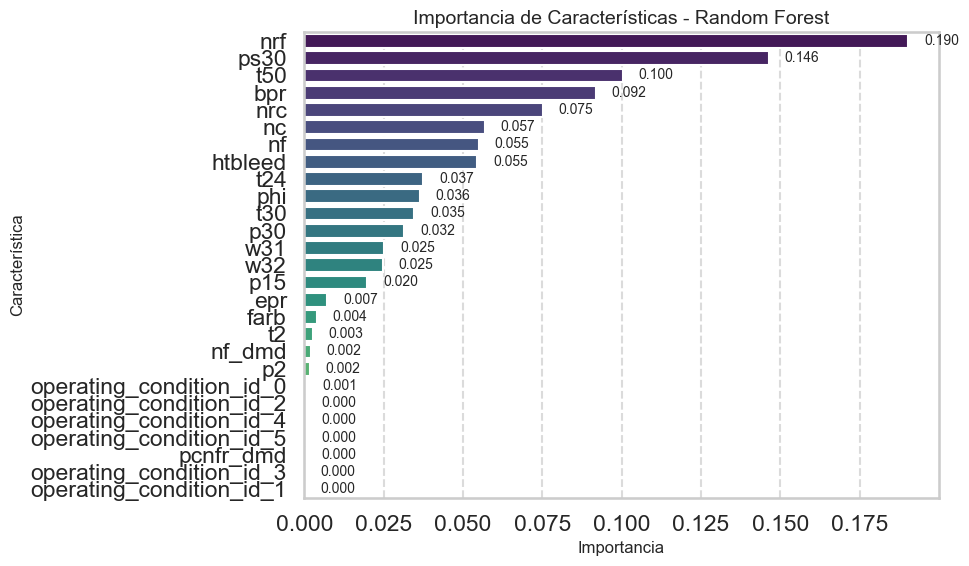

In [ ]:
# Ordenar las importancias
# Crear dataframe de importancias
feat_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

# Gráfico
sns.barplot(
    data=feat_importances,
    x='Importance',
    y='Feature',
    color='#440154',  
    hue='Feature',    
    palette='viridis', 
    dodge=False,      # Evita que separen las barras
    legend=False      # No mostrar leyenda redundante
)

# Personalización del gráfico
plt.title('Importancia de Características - Random Forest', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir valores de importancia a cada barra
for index, value in enumerate(feat_importances['Importance']):
    plt.text(value + 0.005,             # Posición X (valor + pequeño desplazamiento)
            index,                     # Posición Y (índice de la barra)
            f'{value:.3f}',            
            va='center',               
            fontsize=10)              

plt.tight_layout()
plt.show()

Segun Random Forest, las dummies no aportan nada de valor a la predicción del modelo. Adicionalmente los sensores **['p15','p2','nf_dmd','farb','pcnfr_dmd']** que anteriormente se seleccionaron y se eliminaron para probar en el modelo base (dropsensors), pues aquí se observan que aportan muy poco valor para la predicción del modelo.

El sensor que mas aporta a la predicción del modelo es la velocidad relativa de la FAN (nrf).  

In [49]:
# Obtener el modelo optimizado
best_grid_rf = grid_rf.best_estimator_

# Extraer importancia de características
importances = best_grid_rf.named_steps['model'].feature_importances_
selected_features_mask = best_grid_rf.named_steps['feature_selection'].get_support()
feature_names = X_train_encoded.columns[selected_features_mask]

# Crear DataFrame de importancias
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

In [61]:
# Seleccionar top N características
top_n = 20
top_features = feat_imp_df.head(top_n)['Feature'].values

# Filtrar conjuntos de datos
X_train_top = X_train_encoded[top_features]
X_test_top = X_test_encoded[top_features]

In [62]:
# Pipeline simplificado para reevaluación
rf_reeval = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42
    ))
])

# Entrenamiento y evaluación
rf_reeval.fit(X_train_top, y_train)
y_pred = rf_reeval.predict(X_test_top)
y_pred_train = rf_reeval.predict(X_train_top)


In [63]:
evaluate(y_train, y_pred_train, 'train')
evaluate(y_test.clip(upper=125), y_pred)

train set RMSE: 15.6162, R²: 0.8566
test set RMSE: 18.3308, R²: 0.8103


Cuando reentrenamos el mejor modelo con las mejores 20 características o las más importantes este sufre un pequeño bajón de rendimiento en comparación con el modelo optimizado (test set RMSE: 18.2904, R²: 0.8111), lo que confirma de una vez que el modelo mejora con más características del dataset, no es necesario entrenar el modelo con menos carterísticas ya que no compensa el costo computacional un peor rendimiento del modelo. 

### **CONCLUSIONES.**

- El modelo optimizado alcanza un R² de 0.81 en test, lo cual es bastante sólido para un problema de regresión como predicción de RUL. Aunque el RMSE en entrenamiento (15.73) es menor que en prueba (18.29), la diferencia no es excesiva, lo que sugiere que el modelo generaliza bien. Igualmente, los valores de R² en train (0.85) y test (0.81) están relativamente cerca. Aun asi estas métricas hay que seguirlas mejorando.
- El modelo optimizado aprende mejor con más datos; el modelo en sí generaliza muy bien, al punto que mantiene un bajo error de validación y una brecha pequeña respecto al error de entrenamiento. Además, su rendimiento estable sugiere que podría escalar eficientemente a volúmenes mayores de datos, de hecho si tuviera mas datos tendriamos mejores resultados.
-  Con el uso del clip de RUL o al adaptar la variable objetivo a los datos, se obtiene una mejora sustancial en el desempeño del modelo, ya que se evita que la regresión intente predecir valores extremadamente altos de RUL que son poco frecuentes o irrelevantes desde el punto de vista operativo. Este ajuste contribuye a una mejora tanto el error cuadrático medio (RMSE) como la capacidad de generalización (R²) en los datos de prueba. 

En fin el modelo mejora sustancialmente con el uso de la clip en la RUL, el modelo generaliza bien con más datos, sin embargo sera útil probar y comparar con modelos más avanzados como XGboost.